# Stock Pattern Recognition DL

In [1]:
### import library
import numpy as np
import pandas as pd
from cassandra.cluster import Cluster
from scipy.signal import find_peaks
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight, resample
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical

### 1️⃣ ดึงข้อมูลจาก Cassandra

In [2]:
# --------------------------
# 1) Get data from Cassandra
# --------------------------
def get_candlestick_data(symbol: str, limit: int = 3000,
                         contact_points=['127.0.0.1'], port=9042,
                         keyspace='data_stock'):
    cluster = Cluster(contact_points, port=port)
    session = cluster.connect(keyspace)
    query = f"""
        SELECT time, open_price, high_price, low_price, close_price, volume
        FROM candlestick_data
        WHERE symbol = '{symbol}'
        ORDER BY time DESC
        LIMIT {limit}
    """
    rows = session.execute(query)
    df = pd.DataFrame(rows)
    if df.empty:
        raise ValueError("No rows returned from Cassandra - check query/keyspace/table/symbol.")
    df.columns = df.columns.str.strip().str.lower()
    df.rename(columns={
        'open_price': 'open',
        'high_price': 'high',
        'low_price': 'low',
        'close_price': 'close'
    }, inplace=True)
    df = df.sort_values('time')  # oldest -> newest
    df.set_index('time', inplace=True)
    return df


### 2️⃣ Preprocessing & Feature Engineering

In [3]:
# -------------------------------------
# 2) detect_head_shoulders (simple rule)
# -------------------------------------
def detect_head_shoulders(df, distance=5, tolerance=0.05, debug=False):
    prices = df['close'].values
    peaks, _ = find_peaks(prices, distance=distance)
    troughs, _ = find_peaks(-prices, distance=distance)

    patterns = []

    # H&S
    for i in range(2, len(peaks)):
        l, h, r = peaks[i-2], peaks[i-1], peaks[i]
        left, head, right = prices[l], prices[h], prices[r]
        if head > left and head > right and abs(left - right) / max(head,1e-9) < tolerance:
            neck_left = np.min(prices[l:h]) if h - l > 0 else prices[l]
            neck_right = np.min(prices[h:r]) if r - h > 0 else prices[r]
            neck_slope = (neck_right - neck_left) / max((r - l), 1)
            post_pattern = prices[r:]
            neckline_series = neck_right + neck_slope * np.arange(1, len(post_pattern) + 1)
            below = np.where(post_pattern < neckline_series)[0]
            if below.size > 0:
                break_idx = r + int(below[0])
                patterns.append({
                    'type': 'H&S',
                    'left_idx': int(l),
                    'head_idx': int(h),
                    'right_idx': int(r),
                    'neck_slope': float(neck_slope),
                    'break_idx': int(break_idx)
                })
                if debug:
                    print("H&S:", l, h, r, "break:", break_idx)

    # IH&S
    for i in range(2, len(troughs)):
        l, h, r = troughs[i-2], troughs[i-1], troughs[i]
        left, head, right = prices[l], prices[h], prices[r]
        if head < left and head < right and abs(left - right) / max(abs(head),1e-9) < tolerance:
            neck_left = np.max(prices[l:h]) if h - l > 0 else prices[l]
            neck_right = np.max(prices[h:r]) if r - h > 0 else prices[r]
            neck_slope = (neck_right - neck_left) / max((r - l), 1)
            post_pattern = prices[r:]
            neckline_series = neck_right + neck_slope * np.arange(1, len(post_pattern) + 1)
            above = np.where(post_pattern > neckline_series)[0]
            if above.size > 0:
                break_idx = r + int(above[0])
                patterns.append({
                    'type': 'IH&S',
                    'left_idx': int(l),
                    'head_idx': int(h),
                    'right_idx': int(r),
                    'neck_slope': float(neck_slope),
                    'break_idx': int(break_idx)
                })
                if debug:
                    print("IH&S:", l, h, r, "break:", break_idx)

    return patterns




### 3️⃣ สร้าง Label (H&S / IH&S / None)

In [4]:
# -------------------------------------------------
# 3) Create labels array (0 = none, 1 = H&S, 2 = IH&S)
# -------------------------------------------------
import numpy as np

def create_labels_from_patterns(length, patterns):
    labels = np.zeros(length, dtype=np.int32)
    for p in patterns:
        idx = int(p['head_idx'])
        if 0 <= idx < length:
            if p['type'] == 'H&S':
                labels[idx] = 1
            elif p['type'] == 'IH&S':
                labels[idx] = 2
    return labels



### 4️⃣ สร้าง labels สำหรับ Deep Learning

In [5]:
# ----------------------------------------------------
# 4) Preprocess features and create sequences for LSTM
# ----------------------------------------------------
from sklearn.preprocessing import MinMaxScaler

def compute_rsi(series, period=14):
    # Wilder's RSI using EMA
    delta = series.diff()
    up = delta.clip(lower=0)
    down = -1 * delta.clip(upper=0)
    ma_up = up.ewm(alpha=1/period, adjust=False).mean()
    ma_down = down.ewm(alpha=1/period, adjust=False).mean()
    rs = ma_up / (ma_down + 1e-9)
    rsi = 100 - (100 / (1 + rs))
    return rsi

def compute_macd(series, fast=12, slow=26, signal=9):
    ema_fast = series.ewm(span=fast, adjust=False).mean()
    ema_slow = series.ewm(span=slow, adjust=False).mean()
    macd_line = ema_fast - ema_slow
    signal_line = macd_line.ewm(span=signal, adjust=False).mean()
    macd_hist = macd_line - signal_line
    return macd_line, signal_line, macd_hist

def preprocess_and_create_sequences_with_indicators(
    df,
    labels,
    seq_len=30,
    features_cols=None,
    include_indicators=True,
    rsi_period=14,
    macd_fast=12,
    macd_slow=26,
    macd_signal=9
):
    """
    df: DataFrame with columns ['open','high','low','close','volume']
    labels: array length == len(df)
    returns: X, y, scaler
    """
    df2 = df.copy()

    # --- compute indicators (added columns) ---
    if include_indicators:
        # RSI on close
        df2['rsi'] = compute_rsi(df2['close'], period=rsi_period)

        # MACD
        macd_line, signal_line, macd_hist = compute_macd(df2['close'], fast=macd_fast, slow=macd_slow, signal=macd_signal)
        df2['macd'] = macd_line
        df2['macd_signal'] = signal_line
        df2['macd_hist'] = macd_hist

        # log return
        df2['log_return'] = np.log(df2['close']).diff().fillna(0)

    # default features if not provided
    if features_cols is None:
        # include technical indicators as features
        features_cols = ['open', 'high', 'low', 'close', 'volume', 'rsi', 'macd', 'macd_hist', 'log_return']

    # fill NaNs produced by indicators (at start)
    df_features = df2[features_cols].copy()
    df_features = df_features.fillna(method='ffill').fillna(method='bfill').fillna(0)

    # convert to numpy float32
    data = df_features.values.astype(np.float32)

    # scale
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data)

    # create sequences
    Xs, ys = [], []
    for i in range(len(data_scaled) - seq_len):
        Xs.append(data_scaled[i:i+seq_len])
        ys.append(labels[i+seq_len-1])
    X = np.array(Xs)
    y = np.array(ys, dtype=np.int32)

    return X, y, scaler




### 5️⃣ สร้าง LSTM Model ด้วย Keras

In [6]:
# ----------------------------------------------------
# 5) Preprocess data and create time sequences
# ----------------------------------------------------
from sklearn.preprocessing import MinMaxScaler
import numpy as np

def preprocess_and_create_sequences(df, labels, seq_len=30):
    """
    แปลงข้อมูลแท่งเทียนให้เป็นลำดับ (sequence) สำหรับ LSTM
    - df ต้องมีคอลัมน์ OHLCV: open, high, low, close, volume
    - labels คือ label สำหรับแต่ละ time step (0,1,2)
    """
    feature_cols = ['open', 'high', 'low', 'close', 'volume']
    data = df[feature_cols].values

    # Normalization
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data)

    X, y = [], []
    for i in range(seq_len, len(data_scaled)):
        X.append(data_scaled[i-seq_len:i])
        y.append(labels[i])

    X = np.array(X)
    y = np.array(y)
    return X, y, scaler


### 6️⃣ Train / Validate

In [7]:
# ----------------------------------------------------
# 6) Train pipeline including class weighting / balance
# ----------------------------------------------------

# assume functions imported from previous blocks:
# get_candlestick_data, detect_head_shoulders, create_labels_from_patterns,
# preprocess_and_create_sequences, build_lstm_model

def train_pipeline(symbol='PTT.B', cass_limit=3000, seq_len=30,
                   test_size=0.2, detect_distance=5, detect_tolerance=0.05,
                   use_class_weight=True, oversample=False, epochs=50, batch_size=32):
    # fetch
    df = get_candlestick_data(symbol, limit=cass_limit)
    print("Data length:", len(df))

    # detect
    patterns = detect_head_shoulders(df, distance=detect_distance, tolerance=detect_tolerance, debug=False)
    labels = create_labels_from_patterns(len(df), patterns)
    unique, counts = np.unique(labels, return_counts=True)
    print("Label distribution (0/1/2):", dict(zip(unique, counts)))

    # preprocess
    X, y, scaler = preprocess_and_create_sequences(df, labels, seq_len=seq_len)
    print("X,y shapes:", X.shape, y.shape)
    if X.shape[0] == 0:
        raise ValueError("Not enough data to build sequences. Increase cass_limit or reduce seq_len.")

    # split
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, shuffle=False)
    print("Train/Val shapes:", X_train.shape, X_val.shape)

    # class weight
    cw = None
    if use_class_weight:
        classes = np.unique(y_train)
        weights = class_weight.compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
        cw = {int(c): float(w) for c,w in zip(classes, weights)}
        print("Class weights:", cw)

    # optional oversample
    if oversample:
        train_data = list(zip(X_train, y_train))
        df_train = pd.DataFrame(train_data, columns=['X','y'])
        majority = df_train[df_train['y']==0]
        target_n = max(1, int(len(majority)//2))
        frames = [majority]
        for cls in [1,2]:
            subset = df_train[df_train['y']==cls]
            if len(subset) == 0:
                continue
            up = resample(subset, replace=True, n_samples=target_n, random_state=42)
            frames.append(up)
        df_bal = pd.concat(frames).sample(frac=1, random_state=42)
        X_train = np.stack(df_bal['X'].values)
        y_train = np.array(df_bal['y'].values)
        print("After oversample Train shapes:", X_train.shape, y_train.shape)

    # one-hot
    y_train_cat = to_categorical(y_train, num_classes=3)
    y_val_cat = to_categorical(y_val, num_classes=3)

    # build model
    model = build_lstm_model(seq_len, X.shape[2], n_classes=3)
    model.summary()

    # fit with early stopping
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)]
    history = model.fit(X_train, y_train_cat,
                        validation_data=(X_val, y_val_cat),
                        epochs=epochs, batch_size=batch_size,
                        class_weight=cw,
                        callbacks=callbacks,
                        verbose=2)
    return model, history, (X_train, X_val, y_train, y_val, y_train_cat, y_val_cat), scaler, patterns



In [8]:
# 🔁 เรียก train_pipeline เพื่อสร้าง model และข้อมูลทดสอบ
model, history, (X_train, X_val, y_train, y_val, y_train_cat, y_val_cat), scaler, patterns = train_pipeline(
    symbol='PTT.BK',
    cass_limit=2000,   # ถ้าข้อมูลน้อย ลองลดได้ เช่น 1000
    seq_len=30,
    epochs=5,          # ลด epoch เพื่อเทสต์เร็ว
    batch_size=32
)

print("✅ Model created:", model is not None)
print("✅ Validation data:", X_val.shape, y_val.shape)


Data length: 1400
Label distribution (0/1/2): {np.int32(0): np.int64(1347), np.int32(1): np.int64(28), np.int32(2): np.int64(25)}
X,y shapes: (1370, 30, 5) (1370,)
Train/Val shapes: (1096, 30, 5) (274, 30, 5)
Class weights: {0: 0.3456322926521602, 1: 16.606060606060606, 2: 21.49019607843137}


NameError: name 'build_lstm_model' is not defined

### 7️⃣ ใช้โมเดลทำนาย

Confusion Matrix:
[[261   0   0]
 [  6   0   0]
 [  7   0   0]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9526    1.0000    0.9757       261
           1     0.0000    0.0000    0.0000         6
           2     0.0000    0.0000    0.0000         7

    accuracy                         0.9526       274
   macro avg     0.3175    0.3333    0.3252       274
weighted avg     0.9074    0.9526    0.9294       274



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

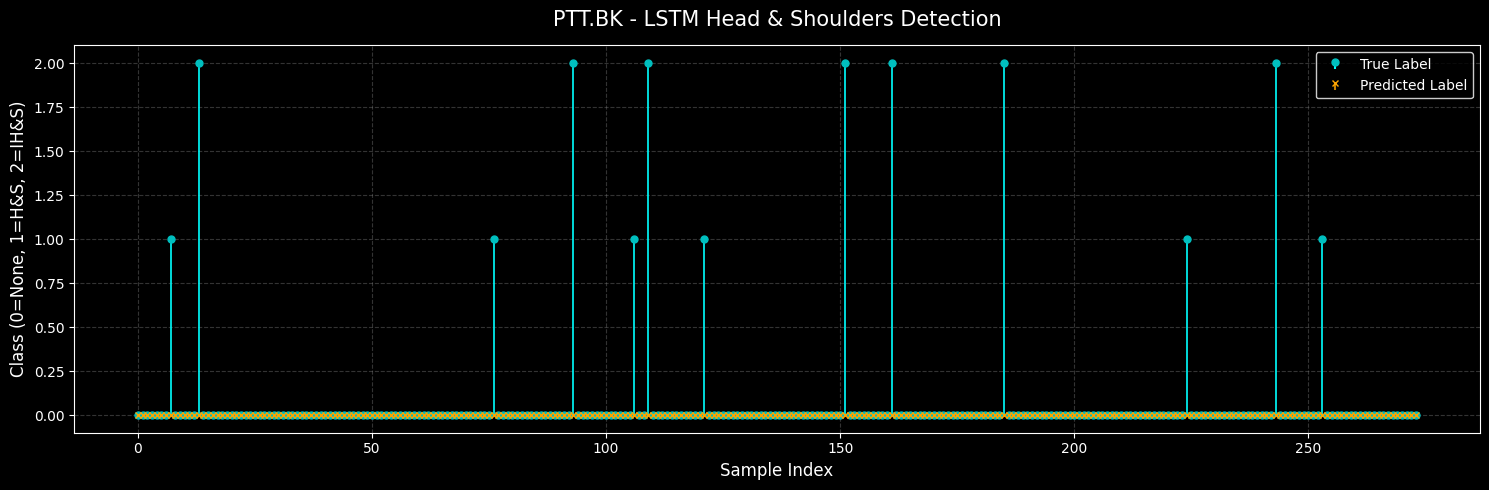

In [ ]:
def evaluate_and_plot(model, X_val, y_val, y_val_cat=None, symbol='SYMBOL'):
    # 🔹 Predict
    y_pred = model.predict(X_val, verbose=0)
    y_pred_cls = np.argmax(y_pred, axis=1)
    y_true_cls = y_val

    # 🔹 Metrics
    print("Confusion Matrix:")
    print(confusion_matrix(y_true_cls, y_pred_cls))
    print("\nClassification Report:")
    print(classification_report(y_true_cls, y_pred_cls, digits=4))

    # --- Dark theme plot ---
    plt.style.use('dark_background')
    fig, ax = plt.subplots(figsize=(15, 5), facecolor='black')

    x = np.arange(len(y_true_cls))

    # 🔹 ใช้ stem plot เพื่อให้เห็น discrete points ชัดเจน
    markerline1, stemlines1, baseline1 = ax.stem(x, y_true_cls, linefmt='cyan', markerfmt='co', basefmt=" ", label='True Label')
    markerline2, stemlines2, baseline2 = ax.stem(x, y_pred_cls, linefmt='orange', markerfmt='x', basefmt=" ", label='Predicted Label')

    # ปรับความหนาและความโปร่ง
    plt.setp(stemlines1, linewidth=1.2)
    plt.setp(stemlines2, linewidth=1.2, alpha=0.8)
    plt.setp(markerline1, markersize=5)
    plt.setp(markerline2, markersize=5)

    ax.set_title(f"{symbol} - LSTM Head & Shoulders Detection", color='white', fontsize=15, pad=14)
    ax.set_xlabel("Sample Index", color='white', fontsize=12)
    ax.set_ylabel("Class (0=None, 1=H&S, 2=IH&S)", color='white', fontsize=12)
    ax.grid(True, color='gray', linestyle='--', alpha=0.4)

    legend = ax.legend(facecolor='black', edgecolor='white')
    for text in legend.get_texts():
        text.set_color('white')

    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')

    plt.tight_layout()
    plt.show()
    
evaluate_and_plot(model, X_val, y_val, y_val_cat, symbol='PTT.BK')


1. ดึงข้อมูล ADVANC.BK (Limit: 100 วัน)...
2. ตรวจจับ Pattern (Classic Method)...

พบรูปแบบ H&S/IH&S ทั้งหมด: 6 จุด
3. แสดงกราฟ Pattern, Neckline และเส้นคาดการณ์...


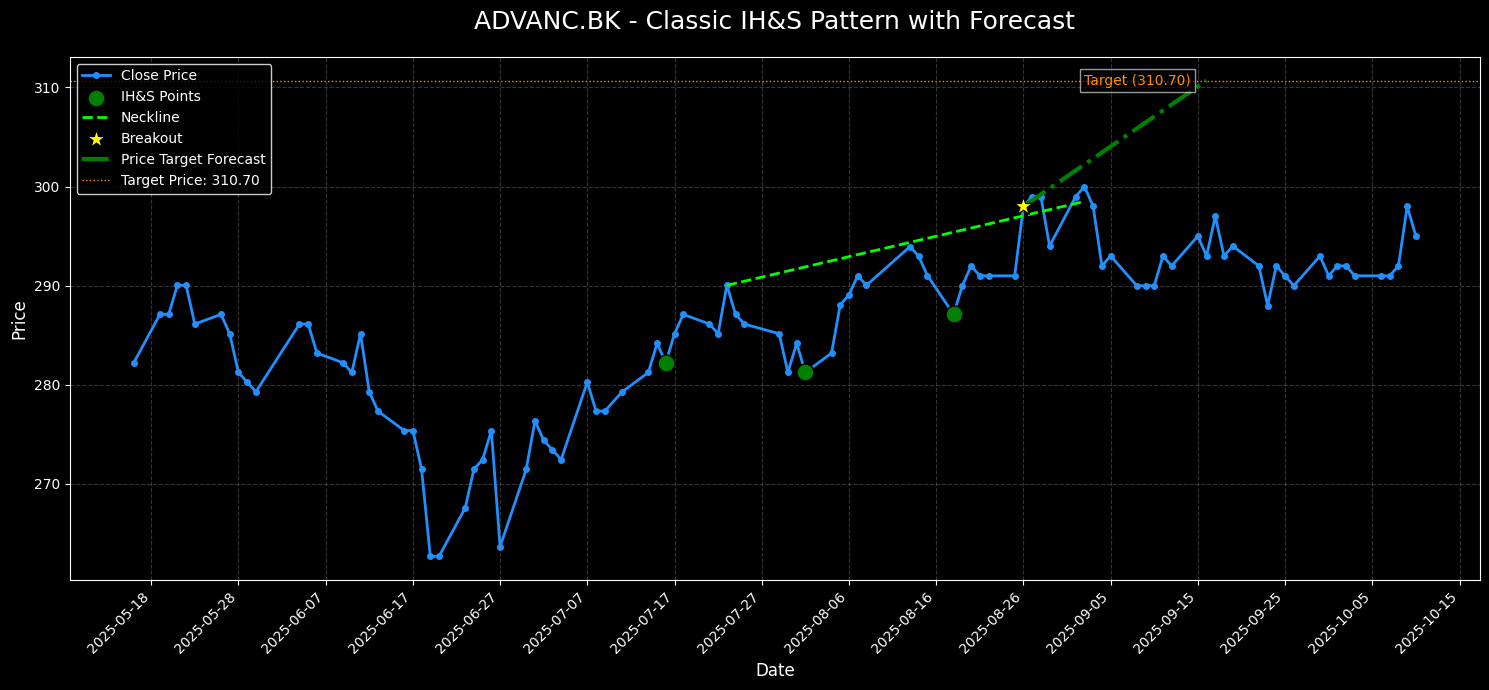

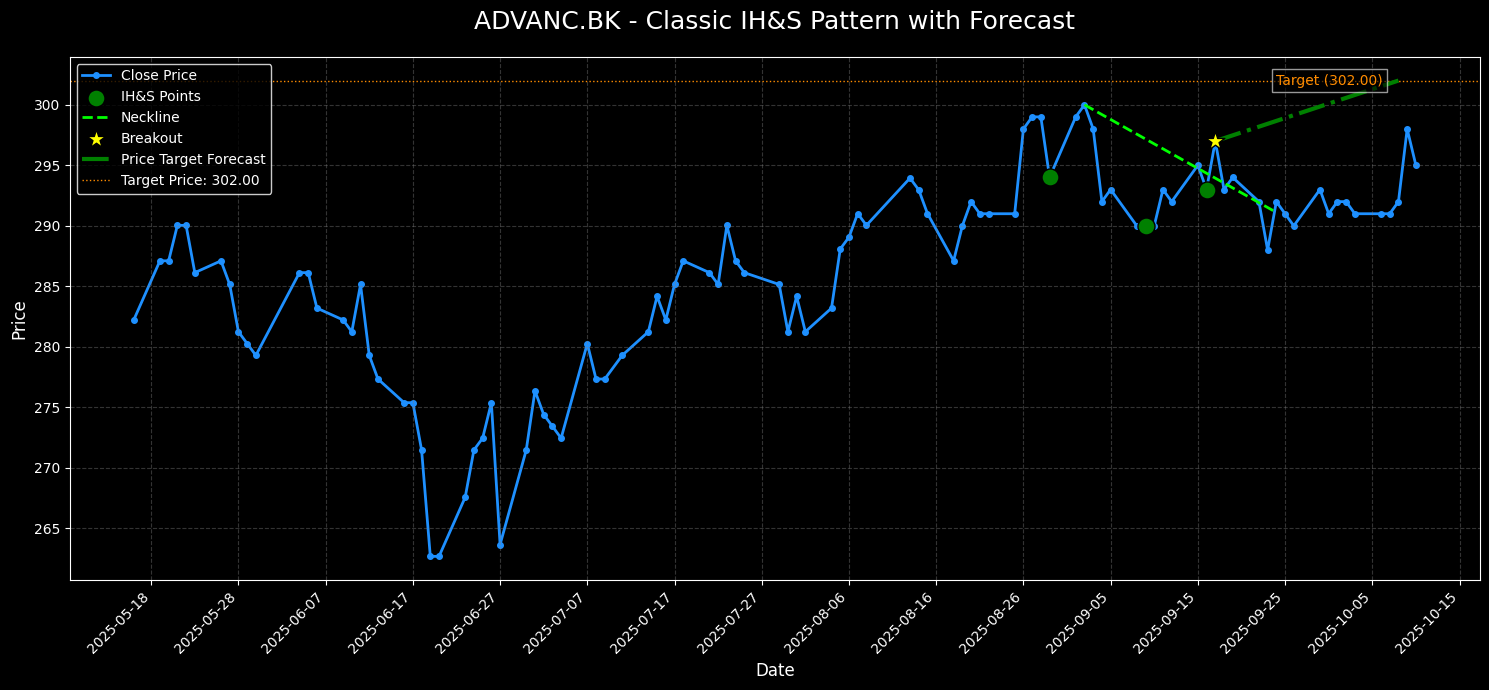

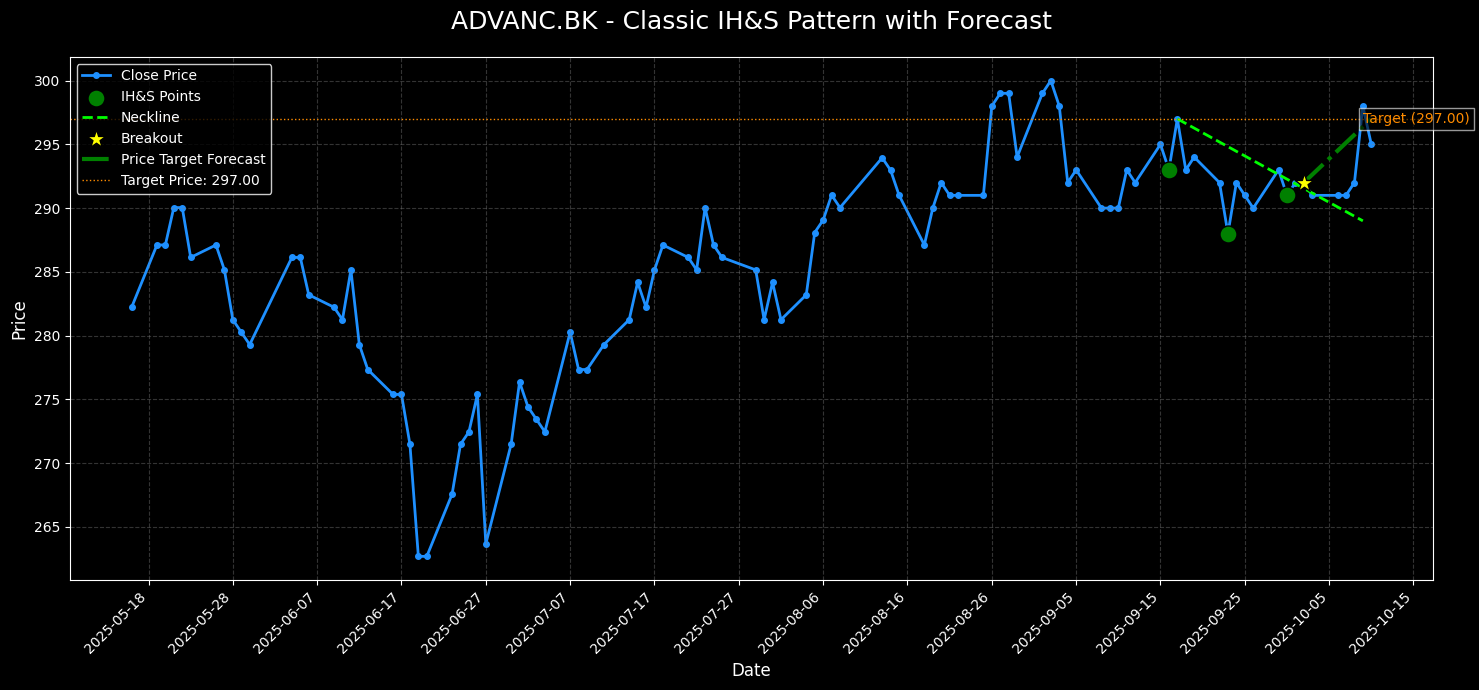

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from cassandra.cluster import Cluster
from scipy.signal import find_peaks

# ----------------------------------------------------
# 1️⃣ ดึงข้อมูลจาก Cassandra (ใช้ limit)
# ----------------------------------------------------
# (ฟังก์ชัน get_candlestick_data เหมือนเดิม)
def get_candlestick_data(symbol: str, limit: int = 3000):
    """ดึงข้อมูลแท่งเทียนจาก Cassandra และจัดรูปแบบ"""
    try:
        # ใช้ Cluster IP/Port ตามที่คุณกำหนด
        cluster = Cluster(['127.0.0.1'], port=9042)
        session = cluster.connect('data_stock')
    except Exception as e:
        print(f"Error connecting to Cassandra: {e}")
        raise ConnectionRefusedError("Could not connect to Cassandra. Check if it's running.")

    query = f"""
        SELECT time, open_price, high_price, low_price, close_price, volume
        FROM candlestick_data
        WHERE symbol='{symbol}'
        ORDER BY time DESC
        LIMIT {limit} 
    """
    rows = session.execute(query)
    df = pd.DataFrame(rows)

    if df.empty:
        raise ValueError(f"No data found for {symbol}")

    df.columns = df.columns.str.lower().str.strip()
    df.rename(columns={
        'open_price': 'open',
        'high_price': 'high',
        'low_price': 'low',
        'close_price': 'close'
    }, inplace=True)

    df = df.sort_values('time')
    df.set_index('time', inplace=True)
    
    df[['open', 'high', 'low', 'close']] = df[['open', 'high', 'low', 'close']].astype(float)
    df['volume'] = df['volume'].astype(float)
    
    return df

# ----------------------------------------------------
# 2️⃣ ตรวจจับ Head & Shoulders (ปรับปรุงให้คำนวณ Neckline และ Breakout)
# ----------------------------------------------------
def detect_head_shoulders(df, distance=5, tolerance=0.05):
    """ตรวจจับรูปแบบ H&S และ IH&S พร้อมหา Neckline และ Breakout"""
    prices = df['close'].values
    peaks, _ = find_peaks(prices, distance=distance)
    troughs, _ = find_peaks(-prices, distance=distance)

    patterns = []
    
    # H&S (ไหล่-หัว-ไหล่) - สัญญาณขาย (Bearish)
    for i in range(2, len(peaks)):
        l, h, r = peaks[i-2], peaks[i-1], peaks[i] # l=ซ้าย, h=หัว, r=ขวา
        if r >= len(prices) - 1: continue # ต้องมีพื้นที่ด้านขวาพอสำหรับ Breakout
            
        left, head, right = prices[l], prices[h], prices[r]
        
        # เงื่อนไข H&S: หัวสูงสุด, ไหล่ซ้าย/ขวาใกล้เคียงกัน
        if head > left and head > right and abs(left - right) / head < tolerance:
            
            # หาจุดฐาน (troughs) ของ Neckline
            trough1_idx = np.argmin(prices[l:h]) + l
            trough2_idx = np.argmin(prices[h:r]) + h

            # คำนวณ Neckline (ลากผ่านฐาน)
            neck_start_price = prices[trough1_idx]
            neck_end_price = prices[trough2_idx]
            
            # Neckline Slope (ความชัน)
            neck_slope = (neck_end_price - neck_start_price) / (trough2_idx - trough1_idx)
            
            # หา Breakout (ราคาปิดต่ำกว่า Neckline)
            post_pattern_prices = prices[trough2_idx + 1:]
            
            # คำนวณราคา Neckline ที่ขยายออกไป
            t_diff = np.arange(1, len(post_pattern_prices) + 1)
            neckline_series = neck_end_price + neck_slope * t_diff
            
            breakout_points = np.where(post_pattern_prices < neckline_series)[0]
            
            if len(breakout_points) > 0:
                break_idx = trough2_idx + 1 + breakout_points[0]
                
                # คำนวณเป้าหมายราคา (วัดจากหัวถึง Neckline)
                target_height = head - prices[trough2_idx]
                target_price = prices[break_idx] - target_height
                
                patterns.append({
                    "type": "H&S", 
                    "l": l, "h": h, "r": r, 
                    "t1": trough1_idx, "t2": trough2_idx, # ฐาน neckline
                    "break_idx": break_idx,
                    "target_price": target_price 
                })

    # IH&S (ไหล่-หัว-ไหล่กลับหัว) - สัญญาณซื้อ (Bullish)
    for i in range(2, len(troughs)):
        l, h, r = troughs[i-2], troughs[i-1], troughs[i]
        if r >= len(prices) - 1: continue
            
        left, head, right = prices[l], prices[h], prices[r]
        
        # เงื่อนไข IH&S: หัวต่ำสุด, ไหล่ซ้าย/ขวาใกล้เคียงกัน
        if head < left and head < right and abs(left - right) / abs(head) < tolerance:
            
            # หาจุดยอด (peaks) ของ Neckline
            peak1_idx = np.argmax(prices[l:h]) + l
            peak2_idx = np.argmax(prices[h:r]) + h

            # คำนวณ Neckline (ลากผ่านยอด)
            neck_start_price = prices[peak1_idx]
            neck_end_price = prices[peak2_idx]
            
            # Neckline Slope (ความชัน)
            neck_slope = (neck_end_price - neck_start_price) / (peak2_idx - peak1_idx)
            
            # หา Breakout (ราคาปิดสูงกว่า Neckline)
            post_pattern_prices = prices[peak2_idx + 1:]
            
            t_diff = np.arange(1, len(post_pattern_prices) + 1)
            neckline_series = neck_end_price + neck_slope * t_diff
            
            breakout_points = np.where(post_pattern_prices > neckline_series)[0]
            
            if len(breakout_points) > 0:
                break_idx = peak2_idx + 1 + breakout_points[0]
                
                # คำนวณเป้าหมายราคา (วัดจากหัวถึง Neckline)
                target_height = prices[peak2_idx] - head
                target_price = prices[break_idx] + target_height
                
                patterns.append({
                    "type": "IH&S", 
                    "l": l, "h": h, "r": r, 
                    "t1": peak1_idx, "t2": peak2_idx, # ฐาน/ยอด neckline
                    "break_idx": break_idx,
                    "target_price": target_price 
                })

    return patterns

# ----------------------------------------------------
# 3️⃣ ฟังก์ชันวาดกราฟและเส้นคาดการณ์ (แทนที่ Deep Learning Plot)
# ----------------------------------------------------
def plot_pattern_with_forecast(df, patterns, symbol='SYMBOL'):
    """วาดกราฟราคา, จุด Pattern, Neckline และเส้นคาดการณ์"""

    plt.style.use('dark_background')
    
    # วาด Pattern ล่าสุด 3 อันเท่านั้น
    patterns_to_plot = patterns[-3:] 
    
    if not patterns_to_plot:
        print(f"ไม่พบรูปแบบ Head & Shoulders/Inverse Head & Shoulders ในข้อมูล {symbol}")
        # วาดกราฟราคาเปล่า
        fig, ax = plt.subplots(figsize=(15, 7), facecolor='black')
        ax.plot(df.index, df['close'], color='gray', linewidth=2, label='Close Price')
        ax.set_title(f"{symbol} - ไม่พบ Pattern", color='white', fontsize=18)
        plt.show()
        return

    for p in patterns_to_plot:
        fig, ax = plt.subplots(figsize=(15, 7), facecolor='black')
        
        prices = df['close'].values
        dates = df.index
        
        # 1. วาดเส้นราคาปิด
        ax.plot(dates, prices, 
                color='dodgerblue', linewidth=2, marker='.', markersize=8, 
                label='Close Price', zorder=1)

        # 2. วาดจุด Pattern (L, H, R)
        points_idx = [p['l'], p['h'], p['r']]
        points_price = prices[points_idx]
        
        ax.scatter(dates[points_idx], points_price,
                   color='red' if p['type'] == 'H&S' else 'green', 
                   s=150, edgecolors='black', marker='o', zorder=5, label=f"{p['type']} Points")
        
        # 3. วาด Neckline
        t1, t2 = p['t1'], p['t2']
        neck_start_date, neck_end_date = dates[t1], dates[t2]
        neck_start_price, neck_end_price = prices[t1], prices[t2]
        
        # ขยาย Neckline เล็กน้อย
        ext_end_date = dates[min(len(dates)-1, p['break_idx'] + 5)]
        
        # คำนวณ Neckline Slope
        neck_slope = (neck_end_price - neck_start_price) / (t2 - t1)
        ext_end_price = neck_end_price + neck_slope * (dates.get_loc(ext_end_date) - t2)
        
        ax.plot([neck_start_date, ext_end_date],
                [neck_start_price, ext_end_price],
                color='lime', linewidth=2, linestyle='--', label='Neckline', zorder=2)
                
        # 4. วาดจุด Breakout
        break_idx = p['break_idx']
        break_date = dates[break_idx]
        break_price = prices[break_idx]
        
        ax.scatter(break_date, break_price,
                   color='yellow', s=200, marker='*', edgecolors='black', 
                   zorder=6, label='Breakout')
                   
        # 5. วาดเส้นคาดการณ์ (Target Forecast Line)
        
        # เริ่มต้นเส้นคาดการณ์ที่จุด Breakout
        target_price = p['target_price']
        
        # คาดการณ์ลากไปถึง 15 วันข้างหน้า (หรือจนกว่าจะถึงจุดสิ้นสุดของข้อมูล)
        forecast_end_date_loc = min(len(dates) - 1, break_idx + 15)
        forecast_end_date = dates[forecast_end_date_loc]
        
        # สร้างเส้นตรงจากจุด Breakout ไปยังเป้าหมายราคาที่วันสุดท้ายของ Forecast
        ax.plot([break_date, forecast_end_date], 
                [break_price, target_price], 
                color='red' if p['type'] == 'H&S' else 'green', 
                linewidth=3, linestyle='-.', 
                label='Price Target Forecast', zorder=3)
        
        # แสดงเป้าหมายราคา
        ax.axhline(target_price, color='darkorange', linestyle=':', linewidth=1, 
                   label=f"Target Price: {target_price:.2f}")
        ax.text(dates[break_idx + 5], target_price, f"Target ({target_price:.2f})", 
                color='darkorange', fontsize=10, verticalalignment='center', 
                bbox=dict(facecolor='black', alpha=0.6, pad=3))

        # --- การปรับแต่งกราฟ ---
        ax.set_title(f"{symbol} - Classic {p['type']} Pattern with Forecast", 
                     color='white', fontsize=18, pad=20)
        ax.set_xlabel("Date", color='white', fontsize=12)
        ax.set_ylabel("Price", color='white', fontsize=12)
        
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        interval = max(1, len(df.index) // 10) 
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=interval))
        plt.xticks(rotation=45, ha='right')
        
        ax.tick_params(axis='x', colors='white')
        ax.tick_params(axis='y', colors='white')
        ax.grid(True, color='gray', linestyle='--', alpha=0.4)

        ax.legend(facecolor='black', edgecolor='white', loc='upper left')
        plt.tight_layout()
        plt.show()

# ----------------------------------------------------
# 🔁 ตัวอย่างการใช้งาน (500 วัน)
# ----------------------------------------------------
if __name__ == '__main__':
    try:
        symbol = "ADVANC.BK"
        # 🔴 กำหนดจำนวนวันข้อมูลที่ต้องการดึง (Limit)
        DATA_LIMIT = 100
        
        # 1. ดึงข้อมูล
        print(f"1. ดึงข้อมูล {symbol} (Limit: {DATA_LIMIT} วัน)...")
        df_original = get_candlestick_data(symbol, limit=DATA_LIMIT)
        
        # 2. ตรวจจับ Pattern
        print("2. ตรวจจับ Pattern (Classic Method)...")
        patterns = detect_head_shoulders(df_original, distance=5, tolerance=0.03) # ลด tolerance ให้เข้มงวดขึ้น
        
        print(f"\nพบรูปแบบ H&S/IH&S ทั้งหมด: {len(patterns)} จุด")

        # 3. แสดงกราฟราคาพร้อมจุด Pattern, Neckline และเส้นคาดการณ์
        print("3. แสดงกราฟ Pattern, Neckline และเส้นคาดการณ์...")
        plot_pattern_with_forecast(df_original, patterns, symbol=symbol)
        
    except ConnectionRefusedError as e:
        print(f"\n❌ การเชื่อมต่อล้มเหลว: {e}")
        print("โปรดตรวจสอบว่า Cassandra Server (127.0.0.1:9042) ได้รันอยู่หรือไม่")
    except ValueError as e:
        print(f"\n❌ ข้อผิดพลาดข้อมูล: {e}")
    except Exception as e:
        print(f"\n❌ เกิดข้อผิดพลาดที่ไม่คาดคิด: {e}")

1. ดึงข้อมูล PTT.BK (Limit: 100 วัน)...
2. สร้าง Label ทิศทาง (1 วันล่วงหน้า)...
3. เตรียม Sequence สำหรับ DL...
   Shape X: (69, 30, 5), Shape y: (69,)
4. คำนวณ Class Weight และสร้างโมเดล...
5. ฝึกโมเดล (Epochs: 5)...
Epoch 1/5


/var/folders/by/j89gc0qj6_zfzkf42sg0dr1c0000gp/T/ipykernel_12092/3024030079.py:163: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(labels[i+seq_len])
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 - 1s - 496ms/step - accuracy: 0.6364 - loss: 0.6742 - val_accuracy: 0.8571 - val_loss: 0.6546
Epoch 2/5
2/2 - 0s - 51ms/step - accuracy: 0.3818 - loss: 0.7134 - val_accuracy: 0.8571 - val_loss: 0.6633
Epoch 3/5
2/2 - 0s - 28ms/step - accuracy: 0.3636 - loss: 0.7162 - val_accuracy: 0.8571 - val_loss: 0.6553
Epoch 4/5
2/2 - 0s - 27ms/step - accuracy: 0.5818 - loss: 0.6791 - val_accuracy: 0.8571 - val_loss: 0.6300
Epoch 5/5
2/2 - 0s - 27ms/step - accuracy: 0.4727 - loss: 0.6971 - val_accuracy: 0.8571 - val_loss: 0.6111

--- Model Evaluation (Validation Set) ---
              precision    recall  f1-score   support

0: Down/Flat       0.86      1.00      0.92        12
       1: Up       0.00      0.00      0.00         2

    accuracy                           0.86        14
   macro avg       0.43      0.50      0.46        14
weighted avg       0.73      0.86      0.79        14


--- 📈 แสดงกราฟ Price Direction Forecast (LSTM) ---

--- Forecast Simulation ---


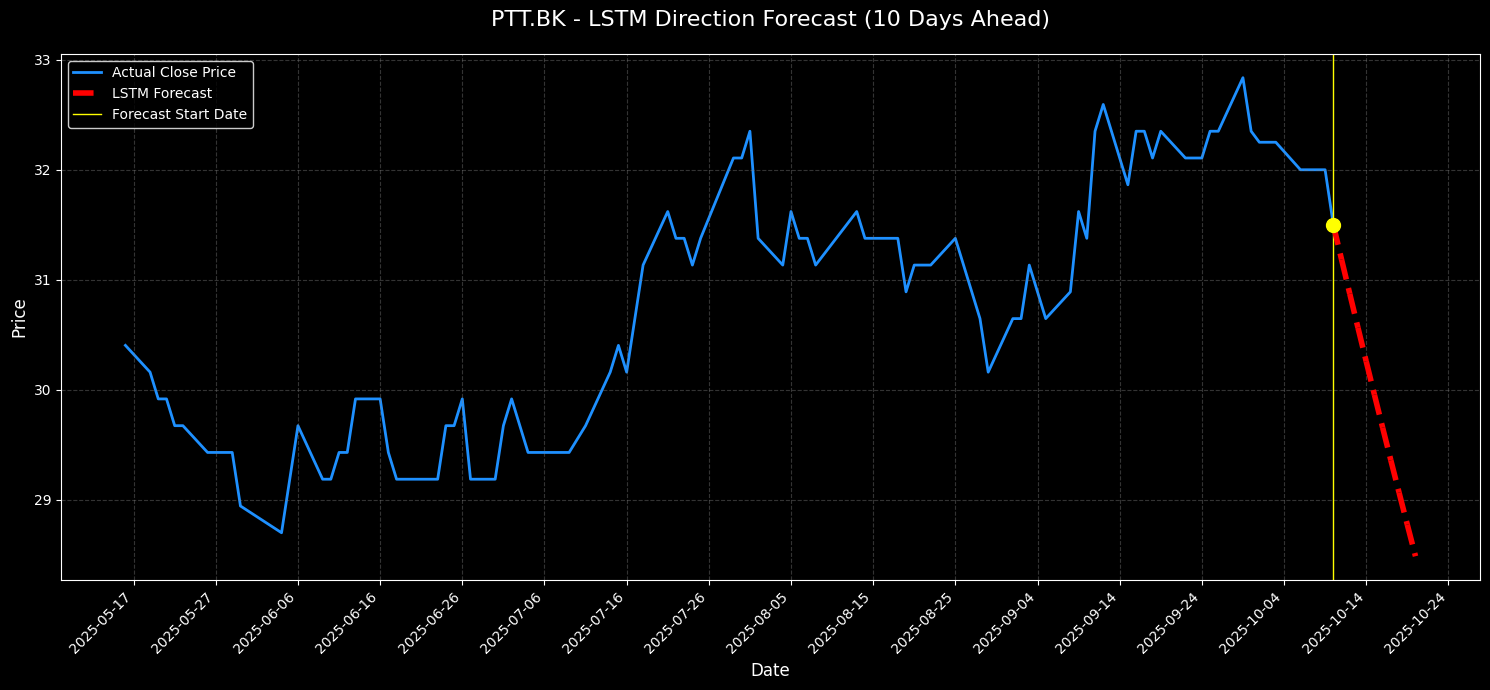


--- 📉 แสดงกราฟ Classic Pattern (H&S/IH&S) ---
พบรูปแบบ H&S/IH&S ทั้งหมด: 2 จุด


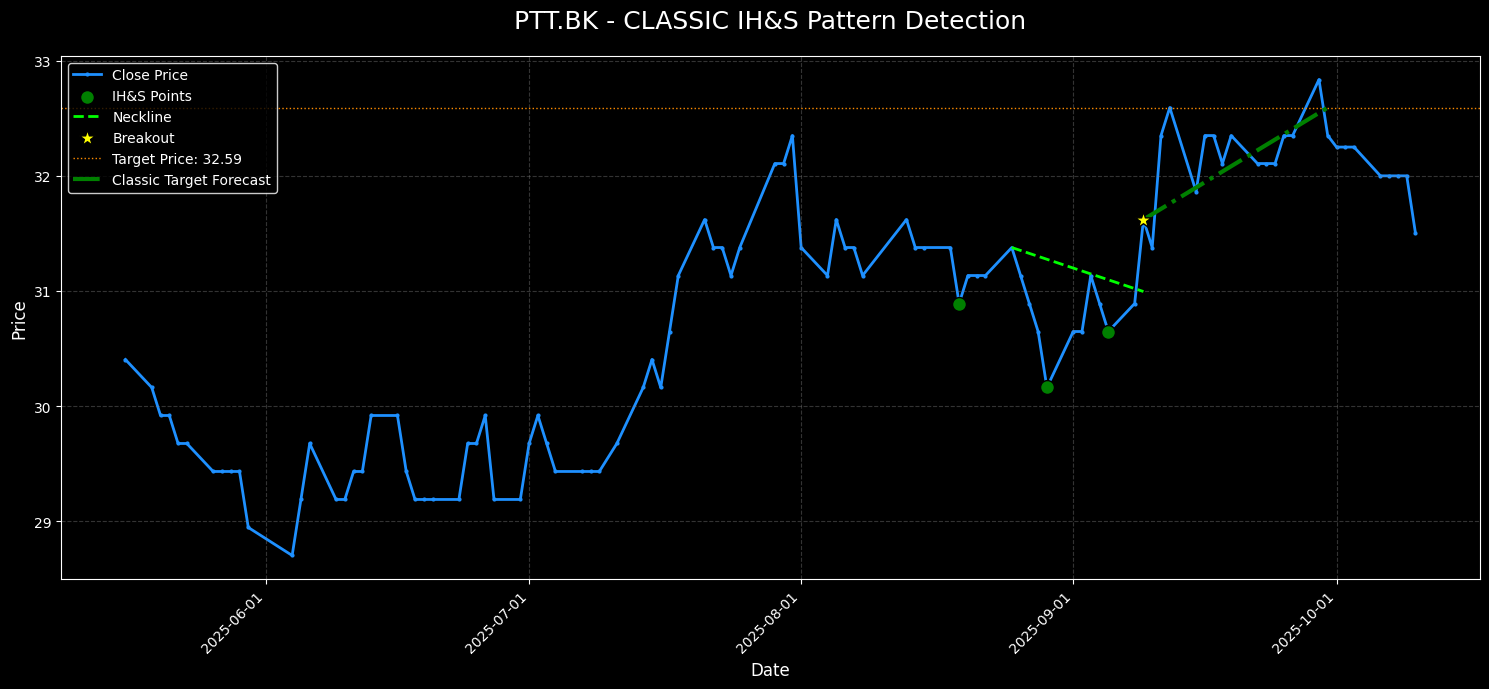

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from cassandra.cluster import Cluster
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
# 🚨 ต้องเพิ่ม import นี้สำหรับการตรวจจับ H&S
from scipy.signal import find_peaks 

# ----------------------------------------------------
# 1️⃣ ดึงข้อมูลจาก Cassandra
# ----------------------------------------------------
def get_candlestick_data(symbol: str, limit: int = 3000):
    """ดึงข้อมูลแท่งเทียนจาก Cassandra และจัดรูปแบบ"""
    try:
        cluster = Cluster(['127.0.0.1'], port=9042)
        session = cluster.connect('data_stock')
    except Exception as e:
        print(f"Error connecting to Cassandra: {e}")
        raise ConnectionRefusedError("Could not connect to Cassandra. Check if it's running.")

    query = f"""
        SELECT time, open_price, high_price, low_price, close_price, volume
        FROM candlestick_data
        WHERE symbol='{symbol}'
        ORDER BY time DESC
        LIMIT {limit} 
    """
    rows = session.execute(query)
    df = pd.DataFrame(rows)

    if df.empty:
        raise ValueError(f"No data found for {symbol}")

    df.columns = df.columns.str.lower().str.strip()
    df.rename(columns={'open_price': 'open', 'high_price': 'high', 'low_price': 'low', 'close_price': 'close'}, inplace=True)
    df = df.sort_values('time')
    df.set_index('time', inplace=True)
    
    df[['open', 'high', 'low', 'close', 'volume']] = df[['open', 'high', 'low', 'close', 'volume']].astype(float)
    
    return df

# ----------------------------------------------------
# 2️⃣ ตรวจจับ Head & Shoulders (H&S/IH&S)
# ----------------------------------------------------
def detect_head_shoulders(df, distance=5, tolerance=0.05):
    """ตรวจจับรูปแบบ H&S และ IH&S พร้อมหา Neckline และ Breakout"""
    prices = df['close'].values
    peaks, _ = find_peaks(prices, distance=distance)
    troughs, _ = find_peaks(-prices, distance=distance)

    patterns = []
    
    # H&S (ไหล่-หัว-ไหล่) - สัญญาณขาย (Bearish)
    for i in range(2, len(peaks)):
        l, h, r = peaks[i-2], peaks[i-1], peaks[i]
        if r >= len(prices) - 1: continue 
            
        left, head, right = prices[l], prices[h], prices[r]
        
        if head > left and head > right and abs(left - right) / head < tolerance:
            trough1_idx = np.argmin(prices[l:h]) + l
            trough2_idx = np.argmin(prices[h:r]) + h

            neck_end_price = prices[trough2_idx]
            neck_start_price = prices[trough1_idx]
            neck_slope = (neck_end_price - neck_start_price) / (trough2_idx - trough1_idx)
            
            post_pattern_prices = prices[trough2_idx + 1:]
            t_diff = np.arange(1, len(post_pattern_prices) + 1)
            neckline_series = neck_end_price + neck_slope * t_diff
            
            breakout_points = np.where(post_pattern_prices < neckline_series)[0]
            
            if len(breakout_points) > 0:
                break_idx = trough2_idx + 1 + breakout_points[0]
                
                target_height = head - prices[trough2_idx]
                target_price = prices[break_idx] - target_height
                
                patterns.append({
                    "type": "H&S", 
                    "l": l, "h": h, "r": r, 
                    "t1": trough1_idx, "t2": trough2_idx, 
                    "break_idx": break_idx,
                    "target_price": target_price 
                })

    # IH&S (ไหล่-หัว-ไหล่กลับหัว) - สัญญาณซื้อ (Bullish)
    for i in range(2, len(troughs)):
        l, h, r = troughs[i-2], troughs[i-1], troughs[i]
        if r >= len(prices) - 1: continue
            
        left, head, right = prices[l], prices[h], prices[r]
        
        if head < left and head < right and abs(left - right) / abs(head) < tolerance:
            
            peak1_idx = np.argmax(prices[l:h]) + l
            peak2_idx = np.argmax(prices[h:r]) + h

            neck_end_price = prices[peak2_idx]
            neck_start_price = prices[peak1_idx]
            neck_slope = (neck_end_price - neck_start_price) / (peak2_idx - peak1_idx)
            
            post_pattern_prices = prices[peak2_idx + 1:]
            
            t_diff = np.arange(1, len(post_pattern_prices) + 1)
            neckline_series = neck_end_price + neck_slope * t_diff
            
            breakout_points = np.where(post_pattern_prices > neckline_series)[0]
            
            if len(breakout_points) > 0:
                break_idx = peak2_idx + 1 + breakout_points[0]
                
                target_height = prices[peak2_idx] - head
                target_price = prices[break_idx] + target_height
                
                patterns.append({
                    "type": "IH&S", 
                    "l": l, "h": h, "r": r, 
                    "t1": peak1_idx, "t2": peak2_idx, 
                    "break_idx": break_idx,
                    "target_price": target_price 
                })
    return patterns

# ----------------------------------------------------
# 3️⃣ สร้าง Label ทิศทาง (0=ลง/คงที่, 1=ขึ้น)
# ----------------------------------------------------
def create_direction_labels(df_close: pd.Series, future_days: int = 1):
    """
    สร้าง Label ทิศทางราคา: 1 ถ้า Close Price ใน 'future_days' วันข้างหน้าขึ้น, 0 ถ้าลงหรือคงที่
    """
    future_price = df_close.shift(-future_days)
    labels = (future_price > df_close).astype(int)
    
    return labels[:-future_days] 

# ----------------------------------------------------
# 4️⃣ เตรียมข้อมูลสำหรับ Deep Learning (สำหรับ 2 Class)
# ----------------------------------------------------
def preprocess_and_create_sequences(df, labels, seq_len=30):
    """ปรับขนาดข้อมูลและสร้าง Time Series Sequence (X) และ Label (y)"""
    features_cols = ['open', 'high', 'low', 'close', 'volume']
    
    df_aligned = df.iloc[:len(labels)] 
    # 🌟 แก้ไข: ใช้ .ffill() แทน fillna(method='ffill') 
    data = df_aligned[features_cols].ffill().values 
    
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data)

    X, y = [], []
    for i in range(len(data_scaled) - seq_len):
        X.append(data_scaled[i:i+seq_len])
        y.append(labels[i+seq_len]) 
        
    X = np.array(X)
    y = np.array(y)
    
    if len(X) == 0:
        raise ValueError("Sequence length is too long for the given data. Check seq_len and data length.")
        
    return X, y, scaler

# ----------------------------------------------------
# 5️⃣ สร้างโมเดล LSTM (Binary Classification)
# ----------------------------------------------------
def build_lstm_model(seq_len, n_features, n_classes=2):
    """สร้างโมเดล LSTM สำหรับการจำแนกประเภททิศทาง (2 Class)"""
    model = Sequential([
        LSTM(64, input_shape=(seq_len, n_features), activation='tanh'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(n_classes, activation='softmax') # n_classes=2
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# ----------------------------------------------------
# 6️⃣ Pipeline ฝึกโมเดล
# ----------------------------------------------------
def train_pipeline(symbol='PTT.BK', cass_limit=1200, seq_len=30, epochs=5, future_days=1):
    """ขั้นตอนการดึงข้อมูล เตรียมข้อมูล และฝึกโมเดล"""
    print(f"1. ดึงข้อมูล {symbol} (Limit: {cass_limit} วัน)...")
    df = get_candlestick_data(symbol, limit=cass_limit)
    
    print(f"2. สร้าง Label ทิศทาง ({future_days} วันล่วงหน้า)...")
    labels = create_direction_labels(df['close'], future_days=future_days)
    
    print("3. เตรียม Sequence สำหรับ DL...")
    X, y, scaler = preprocess_and_create_sequences(df, labels, seq_len)
    
    print(f"   Shape X: {X.shape}, Shape y: {y.shape}")

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)
    y_train_cat = to_categorical(y_train, 2)
    y_val_cat = to_categorical(y_val, 2)

    print("4. คำนวณ Class Weight และสร้างโมเดล...")
    cw = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
    cw = {i: w for i, w in enumerate(cw)}

    model = build_lstm_model(seq_len, X.shape[2], n_classes=2)
    
    print(f"5. ฝึกโมเดล (Epochs: {epochs})...")
    model.fit(X_train, y_train_cat,
              validation_data=(X_val, y_val_cat),
              epochs=epochs, batch_size=32,
              class_weight=cw, verbose=2)
              
    return model, df, scaler, X_val, y_val

# ----------------------------------------------------
# 7️⃣ Plot Forecast: แสดงราคาจริง + เส้นคาดการณ์อนาคต (LSTM)
# ----------------------------------------------------
def plot_future_direction_forecast(df_original, model, scaler, seq_len, symbol='SYMBOL', forecast_steps=10):
    """
    วาดกราฟราคาจริงทั้งหมด พร้อมแสดงการคาดการณ์ราคา 'forecast_steps' วันถัดไป 
    โดยอิงตามทิศทางที่โมเดลทำนาย (จำลองการเปลี่ยนแปลงราคา +/- 1%)
    """
    
    # --- 1. เตรียมข้อมูลสำหรับทำนายอนาคต ---
    
    start_date = df_original.index[-1]
    start_price = df_original['close'].iloc[-1]
    
    features_cols = ['open', 'high', 'low', 'close', 'volume']
    data_last = df_original[features_cols].ffill().values 
    data_scaled_full = scaler.transform(data_last)
    
    last_sequence_scaled = data_scaled_full[-seq_len:]
    
    # --- 2. ทำนายทิศทาง 10 วันถัดไป (จำลองการทำนายแบบก้าวหน้า) ---
    
    # 🌟 แก้ไขข้อผิดพลาด: ลบ closed='right' ออกจาก pd.date_range
    forecast_dates = pd.date_range(start=start_date, periods=forecast_steps + 1)
    
    forecast_prices = [start_price]
    current_price = start_price
    current_sequence = last_sequence_scaled.copy() 

    print("\n--- Forecast Simulation ---")
    for i in range(forecast_steps):
        # ทำนายทิศทางถัดไปจาก Sequence ปัจจุบัน
        X_predict = np.expand_dims(current_sequence, axis=0)
        y_pred_proba = model.predict(X_predict, verbose=0)
        next_direction = np.argmax(y_pred_proba, axis=1)[0]
        
        # ⚠️ Assumption: เปลี่ยนแปลงราคา +/- 1%
        price_change_rate = 0.01 
        if next_direction == 1: # Up
            next_price = current_price * (1 + price_change_rate)
        else: # Down/Flat (0)
            next_price = current_price * (1 - price_change_rate)

        forecast_prices.append(next_price)

        # 3.1. อัปเดต Sequence สำหรับการทำนายรอบถัดไป
        last_features = current_sequence[-1].copy() 
        last_features_unscaled = scaler.inverse_transform(np.expand_dims(last_features, axis=0))[0]
        last_features_unscaled[-2] = next_price # Close Price คือ index -2 
        new_features_scaled = scaler.transform(np.expand_dims(last_features_unscaled, axis=0))[0]
        
        # เลื่อน Sequence: ทิ้งวันแรก และต่อด้วยวันใหม่
        current_sequence = np.concatenate([current_sequence[1:], np.expand_dims(new_features_scaled, axis=0)], axis=0)

        current_price = next_price # อัปเดตราคาปัจจุบัน
        
        
    # --- 3. วาดกราฟ ---
    
    plt.style.use('dark_background')
    fig, ax = plt.subplots(figsize=(15, 7), facecolor='black')
    
    # 3.1. วาดราคาจริง (ทั้งหมด)
    ax.plot(df_original.index, df_original['close'], 
            color='dodgerblue', linewidth=2, label='Actual Close Price', zorder=1)

    # 3.2. วาดเส้นคาดการณ์ (Forecast)
    forecast_dates_full = list(df_original.index[-1:]) + list(forecast_dates[1:])
    
    for i in range(forecast_steps):
        p1 = forecast_prices[i]
        p2 = forecast_prices[i+1]
        d1 = forecast_dates_full[i]
        d2 = forecast_dates_full[i+1]
        
        color = 'green' if p2 > p1 else 'red'
        
        ax.plot([d1, d2], [p1, p2], 
                color=color, linewidth=4, linestyle='--', zorder=5, 
                label='LSTM Forecast' if i == 0 else None)

    # 3.3. จุดเริ่มต้น Forecast
    ax.axvline(start_date, color='yellow', linestyle='-', linewidth=1, label='Forecast Start Date')
    ax.scatter(start_date, start_price, color='yellow', s=100, marker='o', zorder=6)

    # --- ปรับแต่งกราฟ ---
    ax.set_title(f"{symbol} - LSTM Direction Forecast ({forecast_steps} Days Ahead)", 
                 color='white', fontsize=16, pad=20)
    ax.set_xlabel("Date", color='white', fontsize=12)
    ax.set_ylabel("Price", color='white', fontsize=12)
    
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=max(1, len(df_original)//10)))
    plt.xticks(rotation=45, ha='right')
    
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    ax.grid(True, color='gray', linestyle='--', alpha=0.4)
    ax.legend(facecolor='black', edgecolor='white', loc='upper left')

    plt.tight_layout()
    plt.show()

# ----------------------------------------------------
# 8️⃣ Plot Classic Pattern (วาด H&S/IH&S)
# ----------------------------------------------------
def plot_classic_pattern(df, patterns, symbol='SYMBOL'):
    """วาดกราฟราคา, จุด Pattern, Neckline และเส้นคาดการณ์ของ H&S/IH&S"""
    
    plt.style.use('dark_background')
    patterns_to_plot = patterns[-1:] # แสดง Pattern ล่าสุด 1 อันเท่านั้น

    if not patterns_to_plot:
        return

    for p in patterns_to_plot:
        fig, ax = plt.subplots(figsize=(15, 7), facecolor='black')
        prices = df['close'].values
        dates = df.index
        
        # 1. วาดเส้นราคาปิด
        ax.plot(dates, prices, color='dodgerblue', linewidth=2, marker='.', markersize=4, label='Close Price', zorder=1)

        # 2. วาดจุด Pattern (L, H, R)
        points_idx = [p['l'], p['h'], p['r']]
        points_price = prices[points_idx]
        
        ax.scatter(dates[points_idx], points_price,
                   color='red' if p['type'] == 'H&S' else 'green', 
                   s=100, edgecolors='black', marker='o', zorder=5, label=f"{p['type']} Points")
        
        # 3. วาด Neckline 
        t1, t2 = p['t1'], p['t2']
        t1_date, t2_date = dates[t1], dates[t2]
        t1_price, t2_price = prices[t1], prices[t2]
        
        break_idx = p['break_idx']
        break_date = dates[break_idx]
        
        neck_slope = (t2_price - t1_price) / (t2 - t1)
        ext_end_price = t1_price + neck_slope * (break_idx - t1)
        
        ax.plot([t1_date, break_date],
                [t1_price, ext_end_price],
                color='lime', linewidth=2, linestyle='--', label='Neckline', zorder=2)
                
        # 4. วาดจุด Breakout & Target
        break_price = prices[break_idx]
        ax.scatter(break_date, break_price, color='yellow', s=150, marker='*', edgecolors='black', zorder=6, label='Breakout')
                   
        target_price = p['target_price']
        forecast_end_date = dates[min(len(dates) - 1, break_idx + 15)]
        
        # Target Price Line & Forecast Line
        ax.axhline(target_price, color='darkorange', linestyle=':', linewidth=1, label=f"Target Price: {target_price:.2f}")
        ax.plot([break_date, forecast_end_date], 
                [break_price, target_price], 
                color='red' if p['type'] == 'H&S' else 'green', 
                linewidth=3, linestyle='-.', 
                label='Classic Target Forecast', zorder=3)
        
        # --- ปรับแต่งกราฟ ---
        ax.set_title(f"{symbol} - CLASSIC {p['type']} Pattern Detection", color='white', fontsize=18, pad=20)
        ax.set_xlabel("Date", color='white', fontsize=12)
        ax.set_ylabel("Price", color='white', fontsize=12)
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        plt.xticks(rotation=45, ha='right')
        ax.grid(True, color='gray', linestyle='--', alpha=0.4)
        ax.legend(facecolor='black', edgecolor='white', loc='upper left')
        plt.tight_layout()
        plt.show()

# ----------------------------------------------------
# 9️⃣ ตัวอย่างการใช้งาน (รวม Classic Pattern และ DL Forecast)
# ----------------------------------------------------
if __name__ == '__main__':
    try:
        # --- Config ---
        symbol = "PTT.BK"
        DATA_LIMIT = 100  # ใช้ข้อมูลเยอะขึ้นสำหรับการฝึก LSTM
        SEQUENCE_LENGTH = 30
        FUTURE_DAYS = 1   # ทำนายทิศทางของวันถัดไป (1 วัน)
        EPOCHS = 5
        
        # 1. รัน Pipeline (ฝึกโมเดลทำนายทิศทาง 0/1)
        model, df_original, scaler, X_val, y_val = train_pipeline(
            symbol=symbol, 
            cass_limit=DATA_LIMIT, 
            seq_len=SEQUENCE_LENGTH, 
            epochs=EPOCHS,
            future_days=FUTURE_DAYS
        ) 

        # 2. ประเมินผล (แสดงความแม่นยำในการทำนายทิศทาง)
        y_pred = model.predict(X_val, verbose=0)
        y_pred_cls = np.argmax(y_pred, axis=1)
        print("\n--- Model Evaluation (Validation Set) ---")
        print(classification_report(y_val, y_pred_cls, target_names=['0: Down/Flat', '1: Up'], zero_division=0))

        # 3. แสดงกราฟ Price Direction Forecast (LSTM)
        print("\n--- 📈 แสดงกราฟ Price Direction Forecast (LSTM) ---")
        plot_future_direction_forecast(
            df_original, 
            model, 
            scaler, 
            seq_len=SEQUENCE_LENGTH, 
            symbol=symbol, 
            forecast_steps=10
        )
        
        # 4. ตรวจจับและแสดงผล Classic Pattern (H&S/IH&S)
        print("\n--- 📉 แสดงกราฟ Classic Pattern (H&S/IH&S) ---")
        classic_patterns = detect_head_shoulders(df_original, distance=5, tolerance=0.03)
        print(f"พบรูปแบบ H&S/IH&S ทั้งหมด: {len(classic_patterns)} จุด")
        plot_classic_pattern(df_original, classic_patterns, symbol=symbol)
        
    except ConnectionRefusedError as e:
        print(f"\n❌ การเชื่อมต่อล้มเหลว: {e}")
        print("โปรดตรวจสอบว่า Cassandra Server (127.0.0.1:9042) ได้รันอยู่หรือไม่")
    except ValueError as e:
        print(f"\n❌ ข้อผิดพลาดข้อมูล: {e}")
    except Exception as e:
        print(f"\n❌ เกิดข้อผิดพลาดที่ไม่คาดคิด: {e}")